In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

import PIL
import shutil
import zipfile
import glob
import os
import time
import tools

데이터 파싱

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataDir = './dataset/AI-DATASET/data'


trainData_dir = os.path.join(dataDir, 'trainData')
train_dir = os.path.join(dataDir, 'train')
test_dir = os.path.join(dataDir, 'test')

beverage_can_dir = os.path.join(trainData_dir, 'beverage_can')
beverage_bottle_files = os.path.join(trainData_dir, 'beverage_bottle')

beverage_can_files = [f'beverage_can.{i}.jpg' for i in range(1,  501)]
beverage_bottle_files = [f'beverage_bottle.{i}.jpg' for i in range(1,  501)]

# train, valid, test 폴더 생성

train_set_dir = os.path.join(train_dir, 'train')
# os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid')
# os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test')
# os.mkdir(test_set_dir)

"""
for beverage_can, beverage_bottle in zip(beverage_can_files[:300], beverage_bottle_files[:300]):
    src = os.path.join(train_dir, beverage_can)
    dst = os.path.join(train_set_dir, beverage_can)
    shutil.move(src, dst)

    src = os.path.join(train_dir, beverage_bottle)
    dst = os.path.join(train_set_dir, beverage_bottle)
    shutil.move(src, dst)

for beverage_can, beverage_bottle in zip(beverage_can_files[300:400], beverage_bottle_files[300:400]):
    src = os.path.join(train_dir, beverage_can)
    dst = os.path.join(valid_set_dir, beverage_can)
    shutil.move(src, dst)

    src = os.path.join(train_dir, beverage_bottle)
    dst = os.path.join(valid_set_dir, beverage_bottle)
    shutil.move(src, dst)


for beverage_can, beverage_bottle in zip(beverage_can_files[400:500], beverage_bottle_files[400:500]):
    src = os.path.join(train_dir, beverage_can)
    dst = os.path.join(test_set_dir, beverage_can)
    shutil.move(src, dst)

    src = os.path.join(train_dir, beverage_bottle)
    dst = os.path.join(test_set_dir, beverage_bottle)
    shutil.move(src, dst)
"""


'\nfor beverage_can, beverage_bottle in zip(beverage_can_files[:300], beverage_bottle_files[:300]):\n    src = os.path.join(train_dir, beverage_can)\n    dst = os.path.join(train_set_dir, beverage_can)\n    shutil.move(src, dst)\n\n    src = os.path.join(train_dir, beverage_bottle)\n    dst = os.path.join(train_set_dir, beverage_bottle)\n    shutil.move(src, dst)\n\nfor beverage_can, beverage_bottle in zip(beverage_can_files[300:400], beverage_bottle_files[300:400]):\n    src = os.path.join(train_dir, beverage_can)\n    dst = os.path.join(valid_set_dir, beverage_can)\n    shutil.move(src, dst)\n\n    src = os.path.join(train_dir, beverage_bottle)\n    dst = os.path.join(valid_set_dir, beverage_bottle)\n    shutil.move(src, dst)\n\n\nfor beverage_can, beverage_bottle in zip(beverage_can_files[400:500], beverage_bottle_files[400:500]):\n    src = os.path.join(train_dir, beverage_can)\n    dst = os.path.join(test_set_dir, beverage_can)\n    shutil.move(src, dst)\n\n    src = os.path.join(

데이터셋 설정

In [44]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'beverage_can' in files[0]:
            self.label = 0
        else:
            self.label = 1
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

데이터 전처리

In [45]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

train_beverage_can_dataset = CustomDataset(beverage_can_files[:300], train_set_dir, transform=train_transform)
train_beverage_bottle_dataset = CustomDataset(beverage_bottle_files[:300], train_set_dir, transform=train_transform)
valid_beverage_can_dataset = CustomDataset(beverage_can_files[300:400], valid_set_dir, transform=test_transform)
valid_beverage_bottle_dataset = CustomDataset(beverage_bottle_files[300:400], valid_set_dir, transform=test_transform)
test_beverage_can_dataset = CustomDataset(beverage_can_files[400:], test_set_dir, transform=test_transform)
test_beverage_bottle_dataset = CustomDataset(beverage_bottle_files[400:], test_set_dir, transform=test_transform)
 
train_dataset = torch.utils.data.ConcatDataset([train_beverage_can_dataset, train_beverage_bottle_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_beverage_can_dataset, valid_beverage_bottle_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_beverage_can_dataset, test_beverage_bottle_dataset])


print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')
print(f'number of test dataset : {len(test_dataset)}')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

number of train dataset : 600
number of valid dataset : 200
number of test dataset : 200


사용할 모델

In [46]:
model = torchvision.models.resnet50(weights=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.cuda()
summary(model, input_size=(3,224,224))

c:\Users\kde96\.conda\envs\PyeonHaeng\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

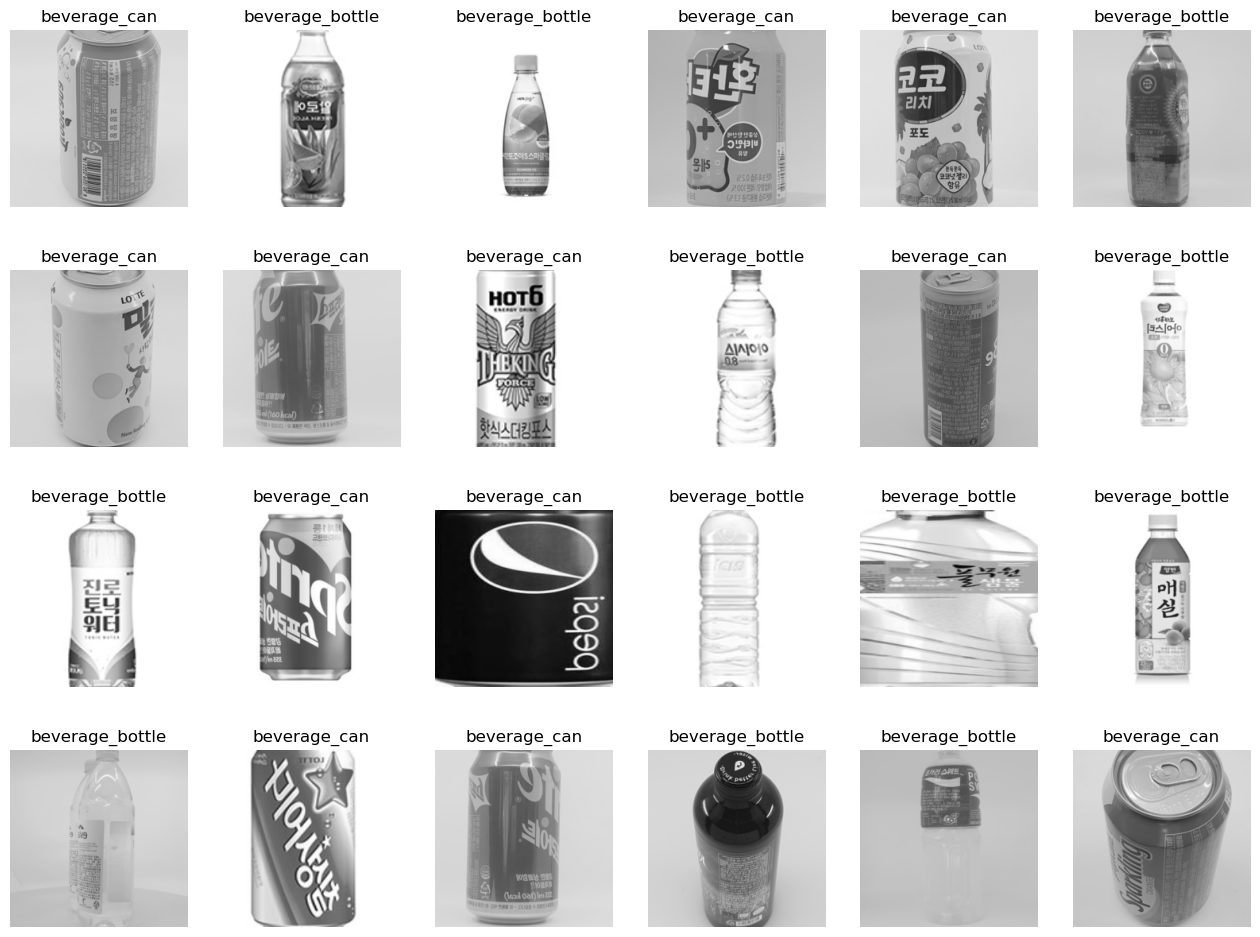

In [47]:
samples, labels = iter(train_loader).__next__()
classes = {0:'beverage_can', 1:'beverage_bottle'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [48]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()
    
    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

SyntaxError: invalid syntax (893142718.py, line 91)

107.651sec : [Epoch 1/10] -> train loss: 0.6478, train acc: 68.833% / valid loss: 0.6053, valid acc: 96.000%
95.480sec : [Epoch 2/10] -> train loss: 0.5004, train acc: 93.167% / valid loss: 0.4683, valid acc: 99.500%
98.823sec : [Epoch 3/10] -> train loss: 0.3248, train acc: 97.000% / valid loss: 0.2902, valid acc: 99.500%
102.794sec : [Epoch 4/10] -> train loss: 0.1738, train acc: 98.333% / valid loss: 0.1392, valid acc: 100.000%
95.164sec : [Epoch 5/10] -> train loss: 0.0859, train acc: 99.500% / valid loss: 0.0975, valid acc: 100.000%
93.868sec : [Epoch 6/10] -> train loss: 0.0400, train acc: 100.000% / valid loss: 0.0719, valid acc: 100.000%
95.937sec : [Epoch 7/10] -> train loss: 0.0239, train acc: 100.000% / valid loss: 0.0407, valid acc: 100.000%
95.676sec : [Epoch 8/10] -> train loss: 0.0169, train acc: 100.000% / valid loss: 0.0308, valid acc: 100.000%
98.356sec : [Epoch 9/10] -> train loss: 0.0133, train acc: 100.000% / valid loss: 0.0275, valid acc: 100.000%
97.041sec : [Epo

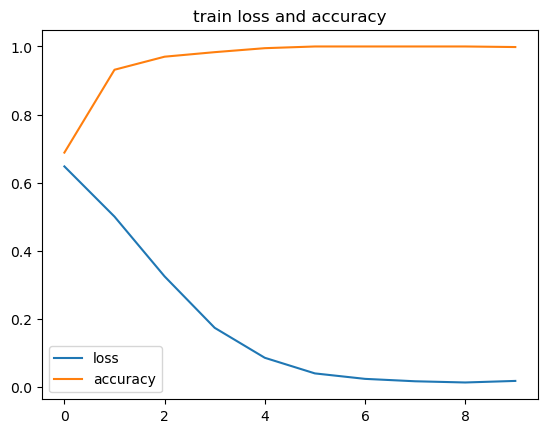

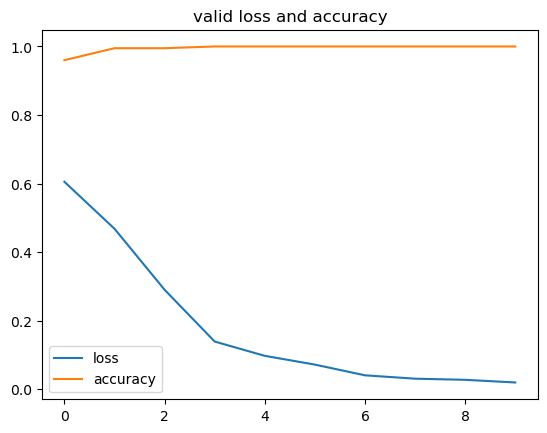

eval loss: 0.0317, eval acc: 99.000%


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
 
fit(model, criterion, optimizer, 10, train_loader, valid_loader)
eval(model, criterion, test_loader)
